In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_mock_inputs(grid_size):
    """
    Generate mock input layers for ignition modeling, all as 2D numpy arrays of shape (grid_size, grid_size).
    Values are generated randomly with proper normalization.

    Returns:
        - Pveg, slope, lightning_density, road_proximity,
          land_use, fire_history, temperature, dryness_index
    """

    rng = np.random.default_rng(seed=42)

    # Vegetation
    Pveg = rng.beta(2, 1.5, size=(grid_size, grid_size))

    # Slope
    slope = rng.beta(2.5, 5, size=(grid_size, grid_size)) * 45  # degrees

    # Lightning: somewhat uniform, low density
    lightning_density = rng.exponential(scale=0.3, size=(grid_size, grid_size))
    lightning_density = np.clip(lightning_density, 0, 1)

    # Road Proximity: mostly far from roads
    road_proximity = rng.beta(3, 1.5, size=(grid_size, grid_size))

    # Land use: randomly assigned (categorical)
    land_use = rng.choice([0, 1, 2], size=(grid_size, grid_size), p=[0.2, 0.6, 0.2])  # 0=urban, 1=forest, 2=grassland

    # Fire history: sparse ignition zones
    fire_history = rng.choice([0, 1], size=(grid_size, grid_size), p=[0.85, 0.15])  # most places never burned

    # Temperature: normally distributed
    temperature = rng.normal(loc=30, scale=5, size=(grid_size, grid_size))

    # Dryness: higher values during fire season
    dryness_index = rng.beta(4, 2, size=(grid_size, grid_size))  # more dry than wet

    return Pveg, slope, lightning_density, road_proximity, land_use, fire_history, temperature, dryness_index

def compute_ignition_probability_map(
    Pveg, slope, lightning_density, road_proximity,
    land_use, fire_history, temperature, dryness_index,
    land_use_weights=None
):
    grid_shape = Pveg.shape
    norm = lambda x: (x - np.min(x)) / (np.max(x) - np.min(x) + 1e-6)
    slope_norm = norm(slope)
    lightning_norm = norm(lightning_density)
    roads_norm = 1 - norm(road_proximity)  # closer to roads = higher ignition
    temp_norm = norm(temperature)
    dryness_norm = norm(dryness_index)
    fire_hist_norm = norm(fire_history)

    land_weight_map = np.zeros_like(land_use, dtype=np.float32)
    if land_use_weights:
        for code, weight in land_use_weights.items():
            land_weight_map[land_use == code] = weight
    else:
        land_weight_map = np.ones_like(Pveg)

    beta = {
        'veg': 0.25,
        'slope': 0.15,
        'lightning': 0.2,
        'roads': 0.1,
        'land_use': 0.15,
        'fire_hist': 0.1,
        'temp': 0.1,
        'dryness': 0.2
    }

    Z = (
        beta['veg'] * Pveg +
        beta['slope'] * slope_norm +
        beta['lightning'] * lightning_norm +
        beta['roads'] * roads_norm +
        beta['land_use'] * land_weight_map +
        beta['fire_hist'] * fire_hist_norm +
        beta['temp'] * temp_norm +
        beta['dryness'] * dryness_norm
    )

    ignition_prob = 1 / (1 + np.exp(-Z))
    return ignition_prob



In [15]:
GRID_SIZE = 50
land_use_weights = {0: 0.1, 1: 0.9, 2: 0.6}  # urban, forest, grassland

Pveg, slope, lightning_density, road_proximity, land_use, fire_history, temperature, dryness_index = generate_mock_inputs(GRID_SIZE)

ignition_map = compute_ignition_probability_map(
    Pveg, slope, lightning_density, road_proximity,
    land_use, fire_history, temperature, dryness_index,
    land_use_weights=land_use_weights
)

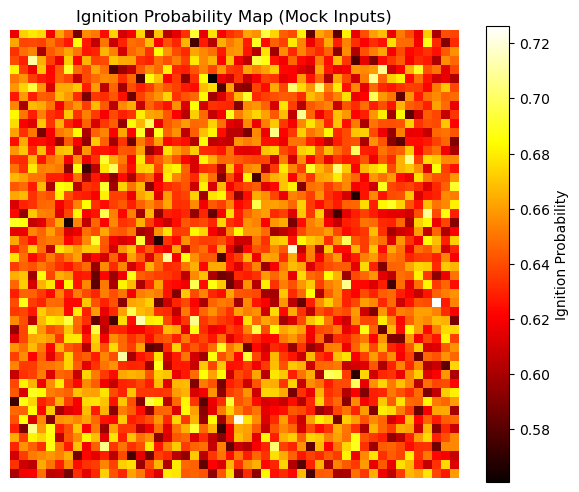

In [16]:
# Plot the ignition probability map
plt.figure(figsize=(6, 5))
plt.imshow(ignition_map, cmap='hot')
plt.title("Ignition Probability Map (Mock Inputs)")
plt.colorbar(label="Ignition Probability")
plt.axis("off")
plt.tight_layout()
plt.show()